In [1]:
import sys
import time
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from neuron import h
neuron_opt_folder = '/Users/daniele/Postdoc/Research/Janelia/neuronopt'
if not neuron_opt_folder in sys.path:
    sys.path.append(neuron_opt_folder)
import cell_utils as cu
import synapses as syn

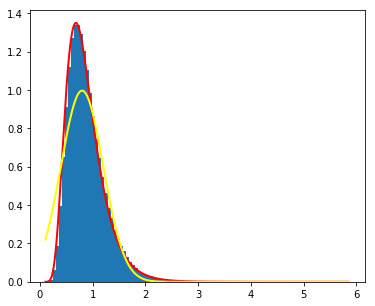

In [2]:
normal = lambda x,m,s: 1./(np.sqrt(2*np.pi*s**2)) * np.exp(-(x-m)**2/(2*s**2))
lognormal = lambda x,m,s: 1./(s*x*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-m)**2/(2*s**2))
mu = np.log(0.8)
sigma = 0.4
rnd = np.random.lognormal(mu,sigma,size=1000000)
count,bins = np.histogram(rnd,100,density=True)
x = np.linspace(min(bins),max(bins),1000)
y = lognormal(x,mu,sigma)
z = normal(x,np.exp(mu),sigma)
plt.figure(figsize=(6,5))
plt.bar(bins[:-1]+np.diff(bins[:2]),count,width=np.diff(bins))
plt.plot(x,y,color=[1,0,0],lw=2)
plt.plot(x,z,color=[1,1,0],lw=2)
plt.show()

In [3]:
folder = '/Users/daniele/Postdoc/Research/Janelia/Optimizations/Thorny/DH070813/BBP_mechanisms/20180315121434_DH070813_/'
swc_file = folder + 'DH070813-.Edit.scaled.converted.swc'
mech_file = folder + 'mechanisms.json'
params_file = folder + 'individual_0.json'

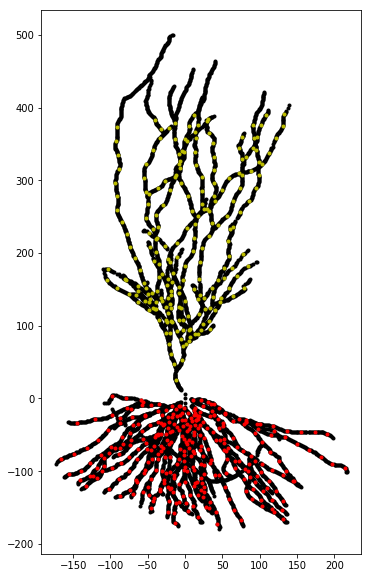

In [4]:
cell = cu.Cell('CA3RS',{'morphology': swc_file,
                        'mechanisms': mech_file,
                        'parameters': params_file})
cell.instantiate()
morpho = np.loadtxt(swc_file)
ratio = (np.max(morpho[:,2])-np.min(morpho[:,2])) / (np.max(morpho[:,3])-np.min(morpho[:,3]))
plt.figure(figsize=(10*ratio,10))
plt.plot(morpho[:,2],morpho[:,3],'k.')
for basal in cell.basal_segments:
    sec = basal['sec']
    seg = basal['seg']
    n3d = int(h.n3d(sec=sec))
    jdx = round(n3d*seg.x)
    x = h.x3d(jdx,sec=sec)
    y = h.y3d(jdx,sec=sec)
    plt.plot(x,y,'r.')
y_coord = [h.y3d(round(h.n3d(sec=segment['sec'])*segment['seg'].x),sec=segment['sec']) \
           for segment in cell.apical_segments]
max_y_coord = max(y_coord) - 100.
for apical,y in zip(cell.apical_segments,y_coord):
    if y < max_y_coord:
        sec = apical['sec']
        seg = apical['seg']
        n3d = int(h.n3d(sec=sec))
        jdx = round(n3d*seg.x)
        x = h.x3d(jdx,sec=sec)
        y = h.y3d(jdx,sec=sec)
        plt.plot(x,y,'y.')
plt.axis('tight')
plt.show()

In [ ]:
def measure_EPSP_responses(swc_file, mech_file, params_file, mu, sigma, scaling=1., slm_border=100.,verbose=False):
    cell = cu.Cell('CA3_cell_%d' % int(time.time()),{'morphology': swc_file,
                                                     'mechanisms': mech_file,
                                                     'parameters': params_file})
    cell.instantiate()
    
    delay = 1000.
    dt = 250.

    # one synapse in each basal segment
    Nsyn = {'basal': len(cell.basal_segments)}
    weights = {'basal': [x if x > 0 else 0 for x in np.random.lognormal(mu,sigma,size=Nsyn['basal'])]}
    synapses = {}
    synapses['basal'] = [syn.AMPANMDASynapse(basal_segment['sec'], basal_segment['seg'].x, 0, [w,scaling*w]) \
                        for basal_segment,w in zip(cell.basal_segments,weights['basal'])]

    # one synapse in each apical segment that is within slm_border um from the tip of the apical dendrites
    y_coord = np.array([h.y3d(round(h.n3d(sec=segment['sec'])*segment['seg'].x),sec=segment['sec']) \
               for segment in cell.apical_segments])
    max_y_coord = max(y_coord) - slm_border
    idx, = np.where(y_coord<max_y_coord)
    Nsyn['apical'] = len(idx)
    weights['apical'] = [x if x > 0 else 0 for x in np.random.lognormal(mu,sigma,size=Nsyn['apical'])]
    synapses['apical']  = [syn.AMPANMDASynapse(cell.apical_segments[i]['sec'], cell.apical_segments[i]['seg'].x, 0, [w,scaling*w]) \
                        for i,w in zip(idx,weights['apical'])]
    
    counter = 0.
    for synapse in synapses.values():
        for s in synapse:
            s.set_presynaptic_spike_times([delay + counter*dt])
            counter+=1
    tend = delay + counter*dt
    if verbose:
        print('Duration of the simulation: %g s.' % (tend*1e-3))
    recorders = {}
    for lbl in 't','V':
        recorders[lbl] = h.Vector()
    recorders['t'].record(h._ref_t)
    recorders['V'].record(cell.morpho.soma[0](0.5)._ref_v)
    
    # run the simulation
    h.cvode_active(1)
    h.tstop = tend
    h.run()
    
    t = np.array(recorders['t'])
    V = np.array(recorders['V'])
    Vrest = V[-1]
    pks = find_peaks(V,height=Vrest+0.1)[0]
    return V[pks] - Vrest

(mu,sigma) = (0.5,0.1): file exists, continuing...
(mu,sigma) = (0.5,0.2): file exists, continuing...
(mu,sigma) = (0.5,0.3): file exists, continuing...
(mu,sigma) = (0.5,0.4): running simulation ..........
Mean EPSP amplitude: 0.597492 mV.


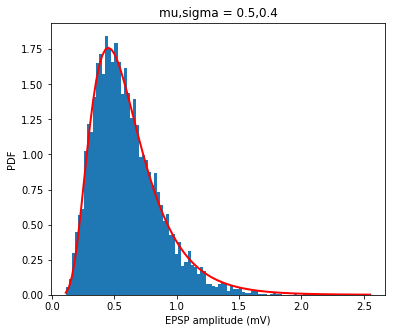

(mu,sigma) = (0.6,0.1): running simulation ..........
Mean EPSP amplitude: 0.671179 mV.


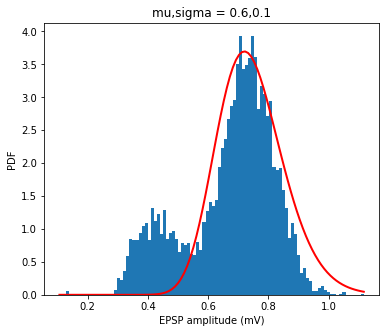

(mu,sigma) = (0.6,0.2): running simulation ..........
Mean EPSP amplitude: 0.67969 mV.


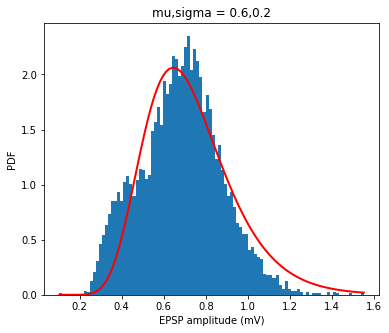

(mu,sigma) = (0.6,0.3): running simulation .......

In [ ]:
reps = 10
scaling = 1.
slm_border = 100.
mus = np.log(np.arange(0.5,0.81,0.1))
sigmas = np.arange(0.1,0.41,0.1)
nbins = 100

force = False

for mu in mus:
    for sigma in sigmas:

        sys.stdout.write('(mu,sigma) = (%g,%g): ' % (np.exp(mu),sigma))
        filename = 'EPSP_amplitudes_mu=%.1f_sigma=%.1f' % (np.exp(mu),sigma)
        
        if any(map(lambda x: filename in x, glob.glob('*.pkl'))) and not force:
            sys.stdout.write('file exists, continuing...\n')
            continue
        
        now = time.localtime(time.time())
        filename = filename + '_%d%02d%02d_%02d%02d%02d' % (now.tm_year,now.tm_mon,now.tm_mday,\
                                                            now.tm_hour,now.tm_min,now.tm_sec)
        
        sys.stdout.write('running simulation ')
        EPSP_amplitudes = np.array([])
        for rep in range(reps):
            sys.stdout.write('.')
            sys.stdout.flush()
            EPSP_amplitudes = np.concatenate((EPSP_amplitudes,measure_EPSP_responses(\
                                            swc_file, mech_file, params_file, mu, sigma,\
                                            scaling, slm_border)))
        
        sys.stdout.write('\n')
        print('Mean EPSP amplitude: %g mV.' % np.mean(EPSP_amplitudes))

        hist,edges = np.histogram(EPSP_amplitudes,nbins,density=True)
        binwidth = np.diff(edges[:2])[0]
        x = edges[:-1] + binwidth/2
        p0 = [np.mean(np.log(EPSP_amplitudes)),np.std(np.log(EPSP_amplitudes))]
        popt,pcov = curve_fit(lognormal,x,hist,p0)

        
        data = {'EPSP_amplitudes': EPSP_amplitudes, 'swc_file': swc_file, 'mech_file': mech_file,\
               'params_file': params_file, 'mu': mu, 'sigma': sigma, 'scaling': scaling, 'slm_border': slm_border,\
               'hist': hist, 'binwidth': binwidth, 'edges': edges, 'popt': popt}
        pickle.dump(data,open(filename+'.pkl','w'))
        
        plt.figure(figsize=(6,5))
        plt.bar(x,hist,width=binwidth)
        plt.plot(edges,lognormal(edges,popt[0],popt[1]),'r',lw=2)
        plt.xlabel('EPSP amplitude (mV)')
        plt.ylabel('PDF')
        plt.title('mu,sigma = %g,%g' % (np.exp(mu),sigma))
        plt.savefig(filename+'.pdf')
        plt.show()
